# 0. Настройка акселератора

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# 1. Загрузка датасета

In [37]:
import pandas as pd
import pickle

In [38]:
with open("data/clean_train.pkl", "rb") as file1:
    train_data = pickle.load(file1)
train_data

[{'prompt': 'Translate the following text from English to Spanish\n\n### English:\nBank card details\n\n### Spanish:\n',
  'translation': 'Detalles de tarjetas bancarias'},
 {'prompt': 'Translate the following text from English to Russian\n\n### English:\nBank card details\n\n### Russian:\n',
  'translation': 'Данные банковских карт'},
 {'prompt': 'Translate the following text from Spanish to English\n\n### Spanish:\nDetalles de tarjetas bancarias\n\n### English:\n',
  'translation': 'Bank card details'},
 {'prompt': 'Translate the following text from Spanish to Russian\n\n### Spanish:\nDetalles de tarjetas bancarias\n\n### Russian:\n',
  'translation': 'Данные банковских карт'},
 {'prompt': 'Translate the following text from Russian to English\n\n### Russian:\nДанные банковских карт\n\n### English:\n',
  'translation': 'Bank card details'},
 {'prompt': 'Translate the following text from Russian to Spanish\n\n### Russian:\nДанные банковских карт\n\n### Spanish:\n',
  'translation': 'De

In [39]:
with open("data/test.pkl", "rb") as file2:
    test_data = pickle.load(file2)
test_data

[{'prompt': 'Translate the following text from English to Spanish\n\n### English:\n2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Spanish:\n',
  'translation': '2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.'},
 {'prompt': 'Translate the following text from English to Russian\n\n### English:\n2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Russian:\n',
  'translation': '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.'},
 {'prompt': 'Translate the following text from Spanish to English\n\n### Spanish:\n2. En la pestaña Amenazas, en la sección Categorías de los objet

# 2. Загрузка базовой модели

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# 3. Токенизация

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [40]:
tokenized_train_dataset = [tokenizer(x["instruction"] + x["text"] + x["translation"]) for x in train_data]
tokenized_test_dataset = [tokenizer(x["instruction"] + x["text"] + x["translation"]) for x in test_data]

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

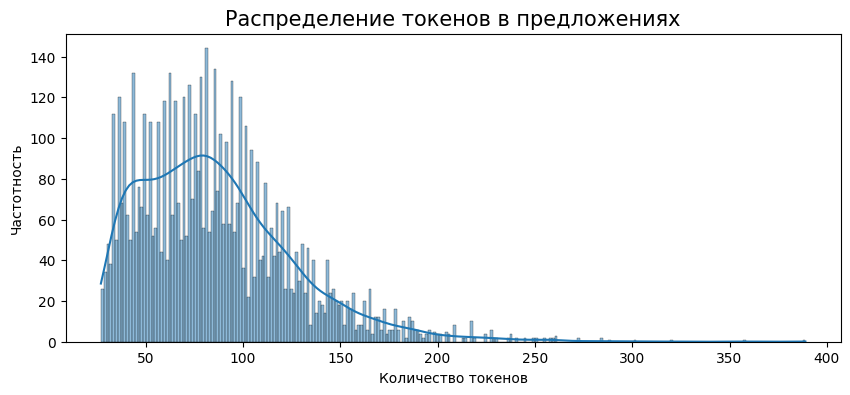

In [44]:
lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
lengths += [len(x['input_ids']) for x in tokenized_test_dataset]

fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(
    data=lengths,
#    x=data,
    bins=250,
    kde=True
)
ax.set(xlabel='Количество токенов', ylabel='Частотность')
ax.set_title(
    "Распределение токенов в предложениях",
    size=15
)
plt.show()

Кажется будто бы можно установить max_length на 256

In [17]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt(x):
    eval_prompt = x["instruction"] + x["text"] + x["translation"]
    result = tokenizer(
        eval_prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = [generate_and_tokenize_prompt(x) for x in train_data]
tokenized_test_dataset = [generate_and_tokenize_prompt(x) for x in test_data]

5904


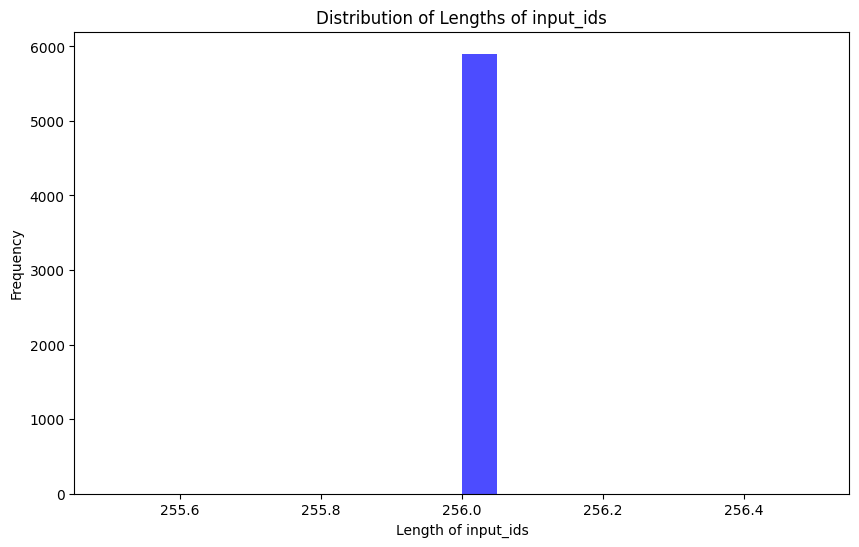

In [19]:
plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset)

# 4. Настройка QLoRA

In [20]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [22]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [23]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [24]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

# 5. Тренировка модели

In [25]:
model = accelerator.prepare_model(model)

In [26]:
import transformers
from datetime import datetime

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir="mistral/peft",
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="mistral/peft/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Currently logged in as: tlinguist. Use `wandb login --relogin` to force relogin


C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.503000,1.241721
50,1.235700,1.150763
75,1.059200,1.068025
100,1.088100,1.039801
125,1.008100,1.028461
150,0.965900,1.020477
175,0.960800,1.013658
200,0.925500,1.006957
225,0.956600,1.004053
250,0.983500,0.992647


C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\peft\utils\save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\alice\AppData\Roaming\Python\Python311\site-packages\peft\utils\save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Sett

TrainOutput(global_step=500, training_loss=0.9974812088012696, metrics={'train_runtime': 3197.9609, 'train_samples_per_second': 0.313, 'train_steps_per_second': 0.156, 'total_flos': 1.1052597116928e+16, 'train_loss': 0.9974812088012696, 'epoch': 0.21})

In [27]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
log_history

,loss,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.5030,0.000024,0.01,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.01,25,1.241721,125.1854,9.490,1.190,NaN,NaN,NaN,NaN,NaN
2,1.2357,0.000023,0.02,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.02,50,1.150763,124.9920,9.505,1.192,NaN,NaN,NaN,NaN,NaN
4,1.0592,0.000021,0.03,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.03,75,1.068025,125.0832,9.498,1.191,NaN,NaN,NaN,NaN,NaN
6,1.0881,0.000020,0.04,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,0.04,100,1.039801,125.3338,9.479,1.189,NaN,NaN,NaN,NaN,NaN
8,1.0081,0.000019,0.05,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.05,125,1.028461,125.1015,9.496,1.191,NaN,NaN,NaN,NaN,NaN


In [28]:
log_history.to_csv("mistral/peft/log_history.csv", index=False)

In [29]:
train_loss = log_history.loss.dropna().to_list()
eval_loss = log_history.eval_loss.dropna().to_list()
epochs = log_history.epoch.drop_duplicates().to_list()

len(train_loss), len(eval_loss), len(epochs)

(20, 20, 20)

In [30]:
train_log = pd.DataFrame({"epochs": epochs, "train_loss": train_loss})
eval_log = pd.DataFrame({"epochs": epochs, "eval_loss": eval_loss})
train_log

,epochs,train_loss
0,0.01,1.5030
1,0.02,1.2357
2,0.03,1.0592
3,0.04,1.0881
4,0.05,1.0081
5,0.06,0.9659
6,0.07,0.9608
7,0.08,0.9255
8,0.10,0.9566
9,0.11,0.9835


In [31]:
train_log.to_csv("mistral/peft/train_log.csv", index=False)
eval_log.to_csv("mistral/peft/eval_log.csv", index=False)

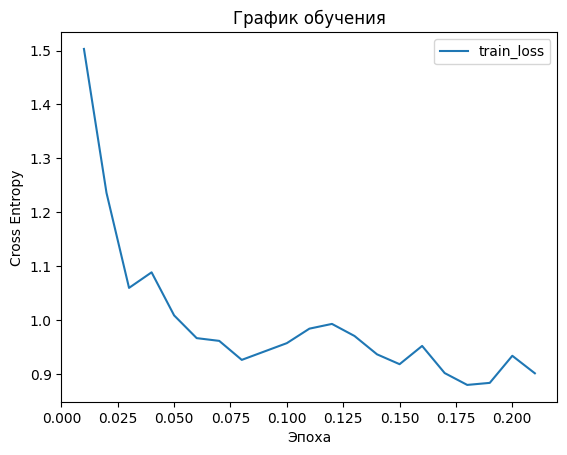

In [32]:
train_log.plot("epochs", "train_loss")
plt.title("График обучения")
plt.xlabel("Эпоха")
plt.ylabel("Cross Entropy")
plt.show()

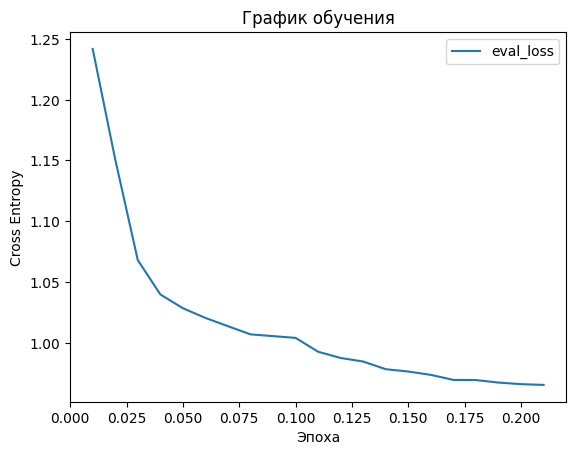

In [33]:
eval_log.plot("epochs", "eval_loss")
plt.title("График обучения")
plt.xlabel("Эпоха")
plt.ylabel("Cross Entropy")
plt.show()

# 6. Запуск обученной модели

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral/peft/checkpoint-425")

In [15]:
import re
from tqdm import tqdm

predictions = []
for sent in tqdm(test_data):
    eval_prompt = sent["prompt"]
    model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        result = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=60, repetition_penalty=1.15)[0], skip_special_tokens=True)
        result = re.sub(f"{eval_prompt} ", "", result)
        predictions.append(result)
predictions

  0%|                                                                                         | 0/1188 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|                                                                               | 1/1188 [00:17<5:50:46, 17.73s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|▏                                                                              | 2/1188 [00:35<5:47:56, 17.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct genera

['Translate the following text from English to Spanish\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Spanish: � 2. En la pestaña Amenazas, en la sección Clases de objetos a analizar, seleccione las casillas de verificaci√≥n correspondientes a las clases de objetos que desea analizar.\n\n### English:',
 'Translate the following text from English to Russian\n\n### English: 2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.\n\n### Russian: �. На вкладке Угрозы в разделе Категории объектов для обнаружения выберите флажки у категорий объектов для обнаружения.\n\n### English: Note: If you have',
 'Translate the following text from Spanish to English\n\n### Spanish: 2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a l

In [88]:
predictions_clean = [re.sub(test_data[n]["prompt"], "", predictions[n]) for n in range(len(predictions))]
predictions_clean = [re.sub("�", "", predictions_clean[n]) for n in range(len(predictions_clean))]
predictions_clean = [re.sub("\n\n### Russian:.*|\n\n### English:.*|\n\n### Spanish:.*", "", predictions_clean[n]) for n in range(len(predictions_clean))]
predictions_clean

[' 2. En la pestaña Amenazas, en la sección Clases de objetos a analizar, seleccione las casillas de verificaci√≥n correspondientes a las clases de objetos que desea analizar.',
 '. На вкладке Угрозы в разделе Категории объектов для обнаружения выберите флажки у категорий объектов для обнаружения.',
 ' 2. On the Threats tab, in the Objects Detected categories section, select the checkboxes for the object categories that you want to scan for.',
 '. На вкладке Угрозы, в разделе Категории обнаруженных объектов, установите флажки для категорий обнаруженных объектов, которые необходимо обнару',
 '. On the Threats tab in the Detected object categories section, select the checkboxes next to the object category types that you want to scan for.\n\n## Contextual help topics',
 '. En la pestaña Amenazas en el panel de categorías de objetos a buscar, marque las casillas de verificación correspondientes a las categorías de objetos que se deben detectar.',
 '· Los programas del tipo de troyanos prox

In [22]:
y_true = [x["translation"] for x in test_data[:len(predictions)]]
y_true

['2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.',
 '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.',
 '2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.',
 '2. На закладке Угрозы в блоке Категории обнаруживаемых объектов установите флажки рядом с категориями объектов, которые программа должна обнаруживать.',
 '2. On the Threats tab, in the Categories of objects to detect section, select the checkboxes next to the categories of objects to detect.',
 '2. En la pestaña Amenazas, en la sección Categorías de los objetos detectados, seleccione las casillas que se encuentran junto a las categorías de objetos que se deben detectar.',
 '· Troyanos-proxy permiten a los hackers 

In [89]:
with open("mistral/peft/preds_postprocess.pkl", "wb") as file3:
    pickle.dump(predictions_clean, file3)
with open("mistral/peft/y_true.pkl", "wb") as file4:
    pickle.dump(y_true, file4)

# 7. Оценка

## Общая оценка

In [24]:
import evaluate
bleu = evaluate.load("bleu")

In [76]:
results = bleu.compute(predictions=predictions_clean, references=y_true)
results

{'bleu': 0.12029983222350361,
 'precisions': [0.24480819979347535,
  0.1429577740382734,
  0.09425457750711166,
  0.06349271495998358],
 'brevity_penalty': 1.0,
 'length_ratio': 2.4899533377773544,
 'translation_length': 52294,
 'reference_length': 21002}

## Оценка по языку

In [77]:
import numpy as np

SIZE = len(y_true)

en2es_idx = np.arange(0, SIZE, 6)
en2ru_idx = np.arange(1, SIZE, 6)
es2en_idx = np.arange(2, SIZE, 6)
es2ru_idx = np.arange(3, SIZE, 6)
ru2en_idx = np.arange(4, SIZE, 6)
ru2es_idx = np.arange(5, SIZE, 6)

In [78]:
en2es_pred, en2ru_pred, es2en_pred, es2ru_pred, ru2en_pred, ru2es_pred = [], [], [], [], [], []
for idx, pred in enumerate(predictions_clean):
    if idx in en2es_idx:
        en2es_pred.append(pred)
    elif idx in en2ru_idx:
        en2ru_pred.append(pred)
    elif idx in es2en_idx:
        es2en_pred.append(pred)
    elif idx in es2ru_idx:
        es2ru_pred.append(pred)
    elif idx in ru2en_idx:
        ru2en_pred.append(pred)
    elif idx in ru2es_idx:
        ru2es_pred.append(pred)
    else:
        print(idx, pred)

In [79]:
len(en2es_pred), len(en2ru_pred), len(es2en_pred), len(es2ru_pred), len(ru2en_pred), len(ru2es_pred)

(198, 198, 198, 198, 198, 198)

In [80]:
en2es_true, en2ru_true, es2en_true, es2ru_true, ru2en_true, ru2es_true = [], [], [], [], [], []
for idx, pred in enumerate(y_true):
    if idx in en2es_idx:
        en2es_true.append(pred)
    elif idx in en2ru_idx:
        en2ru_true.append(pred)
    elif idx in es2en_idx:
        es2en_true.append(pred)
    elif idx in es2ru_idx:
        es2ru_true.append(pred)
    elif idx in ru2en_idx:
        ru2en_true.append(pred)
    elif idx in ru2es_idx:
        ru2es_true.append(pred)
    else:
        print(idx, pred)

In [81]:
en2es_results = bleu.compute(predictions=en2es_pred, references=en2es_true)
en2es_results

{'bleu': 0.14328789568362837,
 'precisions': [0.26634685577223904,
  0.1667554041103184,
  0.11552268030022843,
  0.08215675375208449],
 'brevity_penalty': 1.0,
 'length_ratio': 2.4356108712217424,
 'translation_length': 9589,
 'reference_length': 3937}

In [82]:
en2ru_results = bleu.compute(predictions=en2ru_pred, references=en2ru_true)
en2ru_results

{'bleu': 0.0892498548057877,
 'precisions': [0.20111026999747666,
  0.10766045548654245,
  0.06799468791500664,
  0.0430987452264048],
 'brevity_penalty': 1.0,
 'length_ratio': 2.472239550842171,
 'translation_length': 7926,
 'reference_length': 3206}

In [83]:
es2en_results = bleu.compute(predictions=es2en_pred, references=es2en_true)
es2en_results

{'bleu': 0.12027256448693285,
 'precisions': [0.23130180399804973,
  0.13950482251168342,
  0.09564864590729283,
  0.06779836455853432],
 'brevity_penalty': 1.0,
 'length_ratio': 3.0539011316259677,
 'translation_length': 10255,
 'reference_length': 3358}

In [84]:
en2ru_results = bleu.compute(predictions=es2ru_pred, references=es2ru_true)
en2ru_results

{'bleu': 0.1005521914994673,
 'precisions': [0.2243016375395624,
  0.1223652567548451,
  0.07742686654053267,
  0.04810430091413157],
 'brevity_penalty': 1.0,
 'length_ratio': 2.266687461010605,
 'translation_length': 7267,
 'reference_length': 3206}

In [85]:
ru2en_results = bleu.compute(predictions=ru2en_pred, references=ru2en_true)
ru2en_results

{'bleu': 0.11393274546546303,
 'precisions': [0.24029982363315697,
  0.13759296822177147,
  0.08817427385892117,
  0.05779665015333805],
 'brevity_penalty': 1.0,
 'length_ratio': 2.701608100059559,
 'translation_length': 9072,
 'reference_length': 3358}

In [86]:
ru2es_results = bleu.compute(predictions=ru2es_pred, references=ru2es_true)
ru2es_results

{'bleu': 0.14671348424198502,
 'precisions': [0.3020158827122786,
  0.17766370351821711,
  0.11439209141096418,
  0.07548412593861151],
 'brevity_penalty': 1.0,
 'length_ratio': 2.078994157988316,
 'translation_length': 8185,
 'reference_length': 3937}